READ ME

We start by importing the libraries we will be using

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

We start by loading our data into pandas dataframes. We keep only the closing price of the data, and merge the dataframes into a portfolio dataframe

In [3]:
# Create the individual stocks as dataframes

GOOG = pd.read_csv("/Users/edwardglockner/Library/CloudStorage/OneDrive-Uppsalauniversitet/Fristående Kurser/Inferensteori I/PortfolioOptimization/Data/GOOG.csv", parse_dates=[0], index_col=0)
GOOG.rename(columns={"Close":"GOOG"}, inplace=True)
GOOG.drop(["Open", "High", "Low", "Adj Close", "Volume"], axis=1, inplace=True)

AMZN = pd.read_csv("/Users/edwardglockner/Library/CloudStorage/OneDrive-Uppsalauniversitet/Fristående Kurser/Inferensteori I/PortfolioOptimization/Data/AMZN.csv", parse_dates=[0], index_col=0)
AMZN.rename(columns={"Close":"AMZN"}, inplace=True)
AMZN.drop(["Open", "High", "Low", "Adj Close", "Volume"], axis=1, inplace=True)

TSLA = pd.read_csv("/Users/edwardglockner/Library/CloudStorage/OneDrive-Uppsalauniversitet/Fristående Kurser/Inferensteori I/PortfolioOptimization/Data/TSLA.csv", parse_dates=[0], index_col=0)
TSLA.rename(columns={"Close":"TSLA"}, inplace=True)
TSLA.drop(["Open", "High", "Low", "Adj Close", "Volume"], axis=1, inplace=True)

# Merge the dataframes to a portfolio on date

Portfolio = pd.merge(GOOG,AMZN, on="Date")
Portfolio = pd.merge(Portfolio, TSLA, on="Date")

# Create a training set and a testing set.
# The training set will be used to find an optimal portfolio allocation, and the testing set will be used to test said allocation distribution
Train = Portfolio[0:round(len(Portfolio)*0.85)]
Test = Portfolio[round(len(Portfolio)*0.85): len(Portfolio)]

FileNotFoundError: [Errno 2] No such file or directory: '/Users/edwardglockner/Library/CloudStorage/OneDrive-Uppsalauniversitet/Fristående Kurser/Inferensteori I/Projekt/Data/GOOG.csv'

In [184]:
weights = [1/3, 1/3, 1/3]
ReturnsTraining = Train.pct_change()
ReturnsTraining.head()


,GOOG,AMZN,TSLA
Date,,,
2017-11-30,NaN,NaN,NaN
2017-12-01,-0.011004,-0.012237,-0.007512
2017-12-04,-0.011374,-0.024433,-0.004339
2017-12-05,0.006479,0.006720,-0.004915
2017-12-06,0.013162,0.009443,0.031478


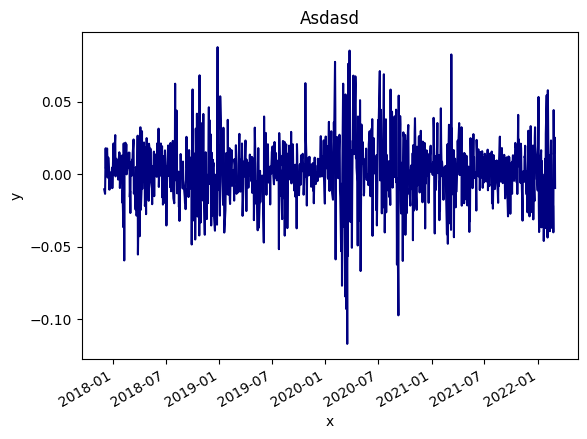

In [185]:
ReturnsAllocated = ReturnsTraining.dot(weights)
plt.figure()
ReturnsAllocated.plot(colormap = "jet", title="Asdasd")	
plt.xlabel("x")
plt.ylabel("y")
plt.show()

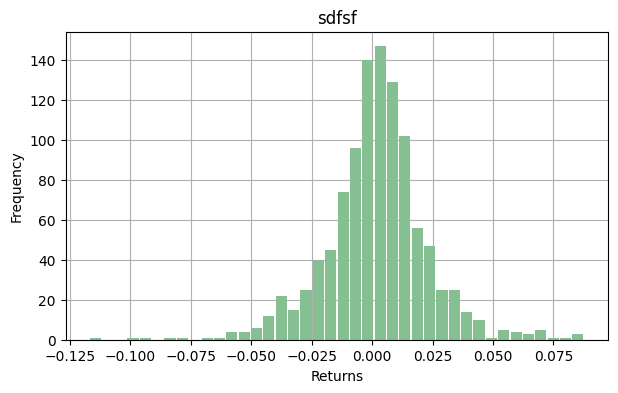

In [186]:
plt.figure()
ReturnsAllocated.hist(bins=40, grid=True, figsize=(7,4), color='#86bf91', zorder=2, rwidth=0.9)
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.title("sdfsf")
plt.show()

In [187]:
VarianceMatrix = ReturnsTraining.cov()*252
VarianceMatrix

,GOOG,AMZN,TSLA
GOOG,0.085453,0.061280,0.070198
AMZN,0.061280,0.102291,0.080757
TSLA,0.070198,0.080757,0.423044


In [188]:
TrainingVariance = np.transpose(weights)@VarianceMatrix@weights
TrainingVolatility = np.sqrt(TrainingVariance)
print(TrainingVariance)
print(TrainingVolatility)


0.11502864436803459
0.3391587303432341


Prepare for the monte carlo simulation

In [189]:
PortfolioReturns = []
PortfolioVolatility = []
PortfolioWeights = []

numAssets = len(Train.columns)
numSimulations = 10000
individual_rets = Train.resample ('Y').last ().pct_change ().mean ()

for port in range (numSimulations):
    # Randomly generate weigh combination
    weights = np.random.random(numAssets)
    # Normalize weight so that they sum to 1
    weights = weights/np.sum(weights)
    PortfolioWeights.append(weights)
    # Returns are the dot product of individual expected returns of asset and its weights
    returns = np. dot (weights, individual_rets)
    PortfolioReturns.append(returns)
    # Computing Portfolio Variance
    var = VarianceMatrix.mul(weights, axis=0) .mul(weights, axis=1) .sum () .sum ()
    # Daily standard deviation : volatility is square root of variance
    sd = np.sqrt(var)
    # Annualizing the standard deviation will give us the volatility
    ann_sd = sd*np.sqrt(250)
    PortfolioVolatility.append(ann_sd)

In [ ]:
# Creating a dictionary of returns and volatility
data = {'Returns' :PortfolioReturns, 'Volatility':PortfolioVolatility}
for counter, symbol in enumerate(Train.columns.tolist ()) :
    data[symbol+' weight'] = [w[counter] for w in PortfolioWeights]

# Converting the dictionary to dataframe
portfolios_V1 = pd. DataFrame (data)

portfolios_V1.head ()

,Returns,Volatility,GOOG weight,AMZN weight,TSLA weight
0,0.899352,6.240137,0.291309,0.228196,0.480495
1,0.287826,4.585031,0.944673,0.016454,0.038872
2,0.266296,4.572468,0.289957,0.690412,0.019631
3,0.441710,4.572014,0.518047,0.333380,0.148573
4,0.479556,4.688140,0.688102,0.134846,0.177051


In [191]:
# Finding the optimal portfolio: Highest SHARPE RATIO
# risk factor
rf = 0.01
optimal_risky_port = portfolios_V1.iloc[((portfolios_V1 ['Returns']-rf)/portfolios_V1['Volatility']). idxmax ( )]
print("Sharp ratio: ",(optimal_risky_port["Returns"]-rf)/optimal_risky_port["Volatility"])
optimal_risky_port

Sharp ratio:  0.15600345661949816


Returns         1.600499
Volatility     10.195279
GOOG weight     0.000509
AMZN weight     0.010154
TSLA weight     0.989337
Name: 2199, dtype: float64

In [194]:
GOOG_weight = optimal_risky_port["GOOG weight"]
AMZN_weight = optimal_risky_port["AMZN weight"]
TSLA_weight = optimal_risky_port["TSLA weight"]
individual_rets_test = Test.resample('Y').last ().pct_change ().mean ()
test_return_1 = np.dot([1/3, 1/3, 1/3], individual_rets_test)
test_return_2 = np.dot([GOOG_weight, AMZN_weight, TSLA_weight], individual_rets_test)
print("Before optimal allocation: ", test_return_1)
print("After optimal allocation: ", test_return_2)

GOOG   NaN
AMZN   NaN
TSLA   NaN
dtype: float64
Before optimal allocation:  nan
After optimal allocation:  nan
